# Load URMP-mono from tfrecords




In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
!pip install -q git+git://github.com/nielsrolf/ddsp

from ddsp.colab import colab_utils

     |████████████████████████████████| 92kB 4.7MB/s 
     |████████████████████████████████| 215kB 29.2MB/s 
     |████████████████████████████████| 3.7MB 35.8MB/s 
     |████████████████████████████████| 368kB 24.8MB/s 
     |████████████████████████████████| 5.6MB 21.9MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 


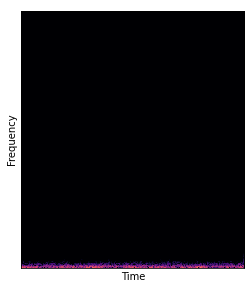

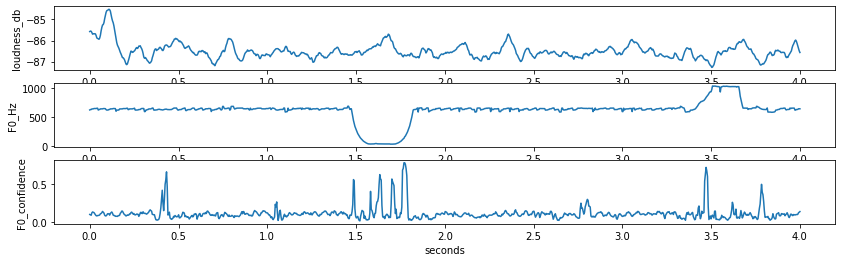

In [3]:
from ddsp.colab import colab_utils
import ddsp.training
from matplotlib import pyplot as plt
import numpy as np

TRAIN_TFRECORD_FILEPATTERN = "drive/MyDrive/ddsp/urmp-mono/group*.tfrecord*"
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=True)

try:
  ex = next(iter(dataset))
except StopIteration:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

ex = next(iter(dataset))
colab_utils.specplot(ex['audio'])
colab_utils.play(ex['audio'])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')
ax[1].plot(x, ex['f0_hz'])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'])

# Initialize GAN

In [4]:
import warnings
warnings.filterwarnings("ignore")

import time

import ddsp
from ddsp.training import (data, decoders, encoders, models, preprocessing, 
                           train_util, trainers, discriminator)
from ddsp.colab.colab_utils import play, specplot, DEFAULT_SAMPLE_RATE
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

sample_rate = 16000
n_samples = 4*sample_rate

## Decoder
- DDSP style decoder, copy from train_autoencoder

In [5]:
TIME_STEPS = 1000

# Create Neural Networks.
preprocessor = preprocessing.F0LoudnessPreprocessor(time_steps=TIME_STEPS)

decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                rnn_type = 'gru',
                                ch = 256,
                                layers_per_stack = 1,
                                input_keys = ('ld_scaled', 'f0_scaled', 'z'),
                                output_splits = (('amps', 1),
                                                 ('harmonic_distribution', 45),
                                                 ('noise_magnitudes', 45)))

# Create Processors.
harmonic = ddsp.synths.Harmonic(n_samples=n_samples, 
                                sample_rate=sample_rate,
                                name='harmonic')

noise = ddsp.synths.FilteredNoise(window_size=0,
                                  initial_bias=-10.0,
                                  name='noise')
add = ddsp.processors.Add(name='add')

# Create ProcessorGroup.
dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
       (noise, ['noise_magnitudes']),
       (add, ['noise/signal', 'harmonic/signal'])]

processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                 name='processor_group')


# Loss_functions
spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)


## Discriminator

In [6]:
from ddsp.training import discriminator

critic = discriminator.ParallelWaveGANDiscriminator(input_keys=['discriminator_audio', 'f0_hz', 'loudness_db'])

## Gan Autoencoder

In [7]:
encoder = encoders.MfccTimeDistributedRnnEncoder(rnn_channels = 512, rnn_type = 'gru', z_dims = 16, z_time_steps = 125)
strategy = train_util.get_strategy()

# Put it together in a model.
model = models.Autoencoder(preprocessor=preprocessor,
                            encoder=encoder,
                            decoder=decoder,
                            processor_group=processor_group,
                            discriminator=critic,
                            losses=[spectral_loss])

outputs = model(ex)
outputs.keys()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


RnnFcDecoder:
{'ld_scaled': TensorShape([1, 1000, 256]), 'f0_scaled': TensorShape([1, 1000, 256]), 'z': TensorShape([1, 1000, 256])}


dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'f0_scaled', 'ld_scaled', 'z', 'amps', 'harmonic_distribution', 'noise_magnitudes', 'harmonic', 'noise', 'add', 'out', 'audio_synth'])

## Analyze output of untrained network

Original Audio


Resynthesized Audio


Filtered Noise Audio


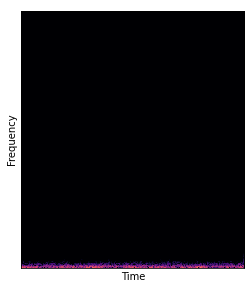

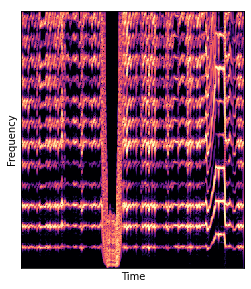

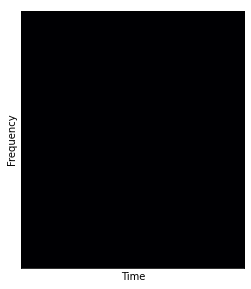

In [8]:
audio_gen = model.get_audio_from_outputs(outputs)

audio = outputs['audio']
print('Original Audio')
play(audio)
print('Resynthesized Audio')
play(audio_gen)
print('Filtered Noise Audio')
audio_noise = outputs['noise']['signal']
play(audio_noise)

specplot(audio)
specplot(audio_gen)
specplot(audio_noise)


# Training
- Copy training loop from demo/train_autoencoder.ipynb

In [ ]:
strategy = train_util.get_strategy()

with strategy.scope():
    TIME_STEPS = 1000

    # Create Neural Networks.
    preprocessor = preprocessing.F0LoudnessPreprocessor(time_steps=TIME_STEPS)

    decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                    rnn_type = 'gru',
                                    ch = 256,
                                    layers_per_stack = 1,
                                    input_keys = ('ld_scaled', 'f0_scaled', 'z'),
                                    output_splits = (('amps', 1),
                                                    ('harmonic_distribution', 45),
                                                    ('noise_magnitudes', 45)))

    # Create Processors.
    harmonic = ddsp.synths.Harmonic(n_samples=n_samples, 
                                    sample_rate=sample_rate,
                                    name='harmonic')

    noise = ddsp.synths.FilteredNoise(window_size=0,
                                    initial_bias=-10.0,
                                    name='noise')
    add = ddsp.processors.Add(name='add')

    # Create ProcessorGroup.
    dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
        (noise, ['noise_magnitudes']),
        (add, ['noise/signal', 'harmonic/signal'])]

    processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                    name='processor_group')


    # Loss_functions
    spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                            mag_weight=1.0,
                                            logmag_weight=1.0)
    
    encoder = encoders.MfccTimeDistributedRnnEncoder(rnn_channels = 512, rnn_type = 'gru', z_dims = 16, z_time_steps = 125)
    
    critic = discriminator.ParallelWaveGANDiscriminator(input_keys=['discriminator_audio', 'f0_hz', 'loudness_db'])
    model = models.Autoencoder(preprocessor=preprocessor,
                                encoder=encoder,
                                decoder=decoder,
                                processor_group=processor_group,
                                discriminator=None,#critic,
                                losses=[spectral_loss])
    trainer = trainers.Trainer(model, strategy, learning_rate=1e-3)
    dataset = trainer.distribute_dataset(dataset)
    trainer.build(next(iter(dataset)))

    dataset_iter = iter(dataset)
    for i in range(300):
        losses = trainer.train_step(dataset_iter)
        res_str = 'step: {}\t'.format(i)
        for k, v in losses.items():
            res_str += '{}: {:.2f}\t'.format(k, v)
        print(res_str)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


RnnFcDecoder:
{'ld_scaled': TensorShape([1, 1000, 256]), 'f0_scaled': TensorShape([1, 1000, 256]), 'z': TensorShape([1, 1000, 256])}
RnnFcDecoder:
{'ld_scaled': TensorShape([1, 1000, 256]), 'f0_scaled': TensorShape([1, 1000, 256]), 'z': TensorShape([1, 1000, 256])}
Model: "autoencoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
f0_loudness_preprocessor_2 ( multiple                  0         
_________________________________________________________________
mfcc_time_distributed_rnn_en multiple                  843852    
_________________________________________________________________
rnn_fc_decoder_2 (RnnFcDecod multiple                  1081179   
_________________________________________________________________
processor_group (ProcessorGr multiple                  0         
_________________________________________________________________
spectral_loss (SpectralLoss) multiple              